## 2 Supervised Learning (16 Pts)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters


scaled_df_train = pd.read_csv('./dataframes/scaled_df_train.csv')
scaled_df_val = pd.read_csv('./dataframes/scaled_df_val.csv')
scaled_df_test = pd.read_csv('./dataframes/scaled_df_test.csv')

### Q2.1 Classic Machine Learning Methods (5 Pts)

Death to no death ratio: 0.14:0.86


/cluster/courses/ml4h/project1env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - AUROC: 0.5151, AUPRC: 0.2783
Random Forest - AUROC: 0.3958, AUPRC: 0.1203


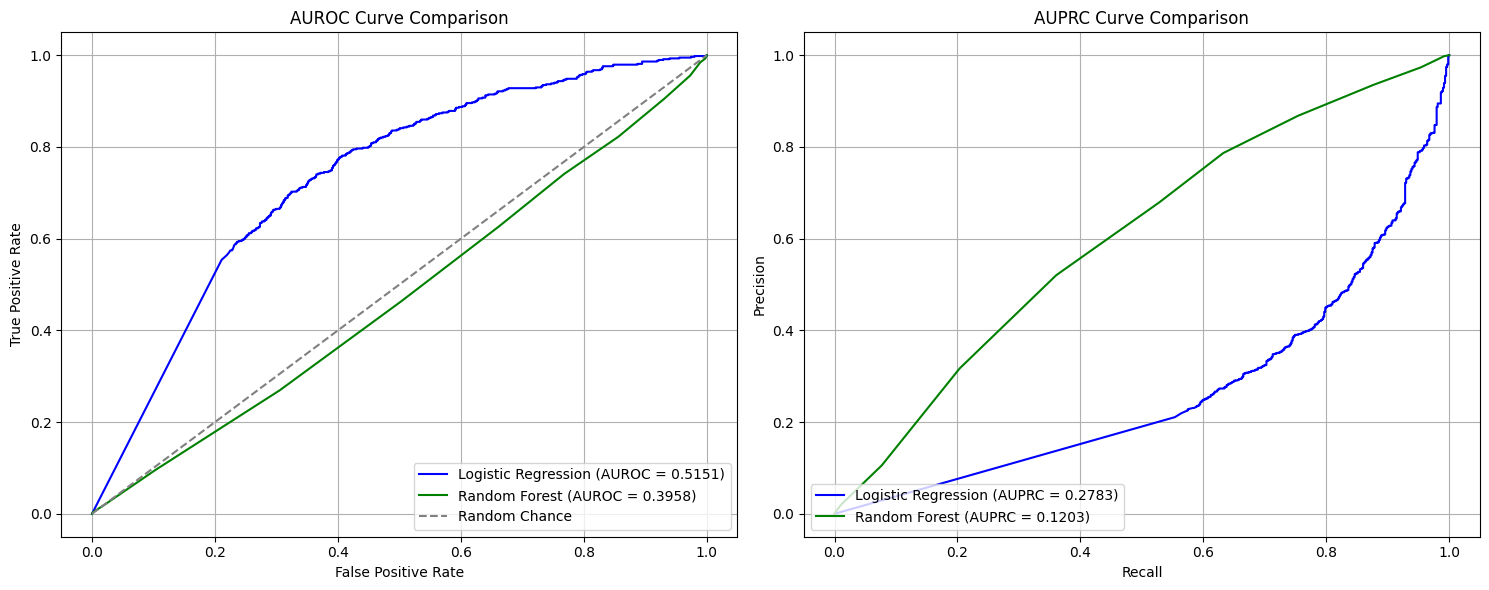

In [3]:
# Step 1: Drop 'ICUType' and 'Hour' columns
non_sequential_df_train = scaled_df_train.drop(columns=['ICUType', 'Hour'])
non_sequential_df_val = scaled_df_val.drop(columns=['ICUType', 'Hour'])
non_sequential_df_test = scaled_df_test.drop(columns=['ICUType', 'Hour'])

# Step 2: Aggregate features for each patient
aggregated_features_train = non_sequential_df_train.groupby('PatientID').agg(['mean', 'max', 'last']).reset_index()
aggregated_features_train.columns = ['_'.join(col).strip('_') for col in aggregated_features_train.columns]
aggregated_features_val = non_sequential_df_val.groupby('PatientID').agg(['mean', 'max', 'last']).reset_index()
aggregated_features_val.columns = ['_'.join(col).strip('_') for col in aggregated_features_val.columns]
aggregated_features_test = non_sequential_df_test.groupby('PatientID').agg(['mean', 'max', 'last']).reset_index()
aggregated_features_test.columns = ['_'.join(col).strip('_') for col in aggregated_features_test.columns]

# Load target variable from 'data/outcome-a.txt'
outcome_path_train = './ml4h_data/p1/Outcomes-a.txt'
train_target = pd.read_csv(outcome_path_train, delimiter=',', index_col=0)['In-hospital_death']
outcome_path_train = './ml4h_data/p1/Outcomes-b.txt'
val_target = pd.read_csv(outcome_path_train, delimiter=',', index_col=0)['In-hospital_death']
outcome_path_test = './ml4h_data/p1/Outcomes-c.txt'
test_target = pd.read_csv(outcome_path_test, delimiter=',', index_col=0)['In-hospital_death']

X_train = aggregated_features_train #.drop(columns='PatientID')
y_train = train_target
X_val = aggregated_features_val #.drop(columns='PatientID')
y_val = val_target
X_test = aggregated_features_test #.drop(columns='PatientID')
y_test = test_target
death_to_no_death_ratio = y_train.value_counts(normalize=True)
print(f"Death to no death ratio: {death_to_no_death_ratio[1]:.2f}:{death_to_no_death_ratio[0]:.2f}")

# Step 4: Train classifiers
# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 5: Evaluate classifiers
# Logistic Regression
lr_probs = lr.predict_proba(X_test)[:, 1]
lr_auroc = roc_auc_score(y_val, lr_probs)
lr_auprc = average_precision_score(y_test, lr_probs)

# Random Forest
rf_probs = rf.predict_proba(X_test)[:, 1]
rf_auroc = roc_auc_score(y_test, rf_probs)
rf_auprc = average_precision_score(y_test, rf_probs)

# Print results
print(f"Logistic Regression - AUROC: {lr_auroc:.4f}, AUPRC: {lr_auprc:.4f}")
print(f"Random Forest - AUROC: {rf_auroc:.4f}, AUPRC: {rf_auprc:.4f}")

# Plot the AUROC and AUPRC curves for both classifiers

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# AUROC Curve
# Logistic Regression
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
axes[0].plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUROC = {lr_auroc:.4f})', color='blue')

# Random Forest
rf_fpr, rf_tpr, _ = roc_curve(y_val, rf_probs)
axes[0].plot(rf_fpr, rf_tpr, label=f'Random Forest (AUROC = {rf_auroc:.4f})', color='green')

# Plot diagonal line for random chance
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance')

# Customize the AUROC plot
axes[0].set_title('AUROC Curve Comparison')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc='lower right')
axes[0].grid()

# AUPRC Curve
# Logistic Regression
precision_lr, recall_lr, _ = roc_curve(y_test, lr_probs)
axes[1].plot(recall_lr, precision_lr, label=f'Logistic Regression (AUPRC = {lr_auprc:.4f})', color='blue')

# Random Forest
precision_rf, recall_rf, _ = roc_curve(y_test, rf_probs)
axes[1].plot(recall_rf, precision_rf, label=f'Random Forest (AUPRC = {rf_auprc:.4f})', color='green')

# Customize the AUPRC plot
axes[1].set_title('AUPRC Curve Comparison')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(loc='lower left')
axes[1].grid()

plt.tight_layout()
plt.show()

Comments: similar perfomance between the models

#### More Features

In [4]:
# Ensure the DataFrame has the required columns
if "PatientID" not in scaled_df_train.columns or "Hour" not in scaled_df_train.columns:
	raise ValueError("scaled_df_train must contain 'PatientID' and 'Hour' columns.")
if "PatientID" not in scaled_df_val.columns or "Hour" not in scaled_df_val.columns:
	raise ValueError("scaled_df_val must contain 'PatientID' and 'Hour' columns.")

# # Ensure y_train and y_val are aligned with the IDs in the DataFrames
# y_train.index = y_train.index.astype(str)  # Convert indices to strings
# y_val.index = y_val.index.astype(str)      # Convert indices to strings
# y_train = y_train.loc[scaled_df_train["PatientID"].unique()]
# y_val = y_val.loc[scaled_df_val["PatientID"].unique()]

# # Extract relevant features
# extracted_features_train = extract_relevant_features(
# 	scaled_df_train, y_train, column_id="PatientID", column_sort="Hour"
# )
# extracted_features_val = extract_relevant_features(
# 	scaled_df_val, y_val, column_id="PatientID", column_sort="Hour"
# )

# # Print the extracted features for verification
# print(extracted_features_train.head())
# print(extracted_features_val.head())

In [6]:
extraction_settings = ComprehensiveFCParameters()

# Combine the training and validation datasets
X_combined = pd.concat([scaled_df_train, scaled_df_test], axis=0)

# Add the target variable to the combined dataset
y_combined = pd.concat([y_train, y_test], axis=0)

print(X_combined.head(),y_combined.head())

   PatientID      Hour  ALP  ALT  AST       Age  Albumin  BUN  Bilirubin  \
0     132539 -1.697056  0.0  0.0  0.0 -0.583612      0.0  0.0        0.0   
1     132539 -1.626346  0.0  0.0  0.0 -0.583612      0.0  0.0        0.0   
2     132539 -1.555635  0.0  0.0  0.0 -0.583612      0.0  0.0        0.0   
3     132539 -1.484924  0.0  0.0  0.0 -0.583612      0.0  0.0        0.0   
4     132539 -1.414214  0.0  0.0  0.0 -0.583612      0.0  0.0        0.0   

   Cholesterol  ...  RespRate  SaO2  SysABP      Temp  TroponinI  TroponinT  \
0          0.0  ...  0.000000   0.0     0.0 -2.111111        0.0        0.0   
1          0.0  ... -0.051293   0.0     0.0 -2.111111        0.0        0.0   
2          0.0  ...  0.000000   0.0     0.0 -2.111111        0.0        0.0   
3          0.0  ...  0.048790   0.0     0.0  0.888889        0.0        0.0   
4          0.0  ...  0.048790   0.0     0.0  0.888889        0.0        0.0   

      Urine  WBC  Weight   pH  
0  0.000000  0.0     0.0  0.0  
1 -0

In [ ]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

X = extract_features(X_combined, column_id='PatientID', column_sort='Hour',
                     default_fc_parameters=extraction_settings,
                     impute_function=impute)

# Ensure PatientID remains as the first column
X.reset_index(inplace=True)
print(X.head())

# Save the extracted features for training and validation datasets
X.to_csv('dataframes/X_features.csv', index=False)


Feature Extraction:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:

X = pd.read_csv('./dataframes/X_all_features.csv')


In [ ]:
# Split X into training and validation sets based on y_train.shape
X_full_train = X.iloc[:y_train.shape[0]]
X_full_val = X.iloc[y_train.shape[0]:]

print(X_full_train.shape, y_train.shape)
print(X_full_val.shape, y_val.shape)

# Reset the PatientID column in X_full_train and X_full_val to match y_train and y_val indices
X_full_train.insert(0, 'PatientID', y_train.index)
X_full_val.insert(0, 'PatientID', y_val.index)
X_full_train.set_index('PatientID', inplace=True)
X_full_val.set_index('PatientID', inplace=True)

print("Selecting features...")
X_filtered_train = select_features(X_full_train, y_train)
X_filtered_train.to_csv('dataframes/X_filtered_train.csv')
X_filtered_train.head()

In [ ]:
X_filtered_train, X_filtered_val = X_filtered_train[X_filtered_train.columns], X_filtered_train[X_filtered_train.columns]

print(X_filtered_train.head(), X_filtered_val.head(), y_train.head(), y_val.head())


In [ ]:

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_filtered_train, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_filtered_train, y_train)

# Step 5: Evaluate classifiers
# Logistic Regression
lr_probs = lr.predict_proba(X_filtered_val)[:, 1]
lr_auroc = roc_auc_score(y_val, lr_probs)
lr_auprc = average_precision_score(y_val, lr_probs)

# Random Forest
rf_probs = rf.predict_proba(X_filtered_val)[:, 1]
rf_auroc = roc_auc_score(y_val, rf_probs)
rf_auprc = average_precision_score(y_val, rf_probs)

# Print results
print(f"Logistic Regression - AUROC: {lr_auroc:.4f}, AUPRC: {lr_auprc:.4f}")
print(f"Random Forest - AUROC: {rf_auroc:.4f}, AUPRC: {rf_auprc:.4f}")

# Plot the AUROC and AUPRC curves for both classifiers

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# AUROC Curve
# Logistic Regression
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr_probs)
axes[0].plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUROC = {lr_auroc:.4f})', color='blue')

# Random Forest
rf_fpr, rf_tpr, _ = roc_curve(y_val, rf_probs)
axes[0].plot(rf_fpr, rf_tpr, label=f'Random Forest (AUROC = {rf_auroc:.4f})', color='green')

# Plot diagonal line for random chance
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance')

# Customize the AUROC plot
axes[0].set_title('AUROC Curve Comparison')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc='lower right')
axes[0].grid()

# AUPRC Curve
# Logistic Regression
precision_lr, recall_lr, _ = roc_curve(y_val, lr_probs)
axes[1].plot(recall_lr, precision_lr, label=f'Logistic Regression (AUPRC = {lr_auprc:.4f})', color='blue')

# Random Forest
precision_rf, recall_rf, _ = roc_curve(y_val, rf_probs)
axes[1].plot(recall_rf, precision_rf, label=f'Random Forest (AUPRC = {rf_auprc:.4f})', color='green')

# Customize the AUPRC plot
axes[1].set_title('AUPRC Curve Comparison')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(loc='lower left')
axes[1].grid()

plt.tight_layout()
plt.show()

In [1]:
## Q2.2 Recurrent Neural Networks (4 Pts)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm import tqdm

# Prepare the data for LSTM
scaler = MinMaxScaler()
X_train_scaled = scaled_df_train.drop(columns=['PatientID', 'Hour'])
X_val_scaled = scaled_df_test.drop(columns=['PatientID', 'Hour'])

# Reshape the data to 3D for LSTM (samples, timesteps, features)
# Group by PatientID and reshape the data to have 48 timesteps per patient
X_train_grouped = X_train_scaled.groupby(scaled_df_train['PatientID']).apply(lambda x: x.values[:48])
X_val_grouped = X_val_scaled.groupby(scaled_df_val['PatientID']).apply(lambda x: x.values[:48])

X_train_lstm = np.stack(X_train_grouped.values)
X_val_lstm = np.stack(X_val_grouped.values)

print(f"X_train_lstm shape: {X_train_lstm.shape}")  # Expected: (4000, 48, num_features)
print(f"X_val_lstm shape: {X_val_lstm.shape}")      # Expected: (4000, 48, num_features)


# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
# Add a time bar for epochs
for epoch in tqdm(range(10), desc="Training Progress"):
    history = model.fit(X_train_lstm, y_train, epochs=1, batch_size=32, validation_data=(X_val_lstm, y_val), verbose=1)

# Evaluate the model
y_val_pred = model.predict(X_val_lstm).flatten()
lstm_auroc = roc_auc_score(y_val, y_val_pred)
lstm_auprc = average_precision_score(y_val, y_val_pred)

print(f"LSTM - AUROC on test set C: {lstm_auroc:.4f}, AUPRC on test set C: {lstm_auprc:.4f}")

ModuleNotFoundError: No module named 'tensorflow'

In [4]:
# Neural networks can learn to extract relevant features
# from the data, as such, you can more or less pass your output from Q1.3 directly to the
# network. While a recurrent neural network will produce an output at every time-step we can
# only leverage one to make the final prediction, which one should you use? Maybe you can
# also aggregate them?

# Answer: The Last Time Step Output (return_sequences=False)
# Using the last hidden state of the LSTM is common, as it contains information aggregated from the entire sequence.
# Why? The last time step holds the most contextualized representation of the input.